## 12. Time Series

[![Python Data Science](https://apmonitor.com/che263/uploads/Begin_Python/DataScience12.png)](https://www.youtube.com/watch?v=EO_YpBs8cs0 "Python Data Science")

**Time series** data is produced sequentially as new measurements are recorded. Models derived from the data give insight into what happens next. They also show how the system can be changed to achieved a different future outcome. Time series models are a representation of a dynamic system in discrete time. Putting a model into time series form is the basis for many methods in dynamics and control. A **digital twin** is a virtual representation of a process that runs in parallel to the physical system. A time series model can be considered a digital twin in the narrow definition of just specific inputs and outputs included in the model. Below is the time series model with a single input `u` and single output `y` with `k` as an index that refers to the time step.

$y_{k+1} = \sum_{i=1}^{n_a} a_i y_{k-i+1} + \sum_{i=1}^{n_b} b_i u_{k-i+1}$

Time series models are used for identification and control. There is additional information on specific types of time-series and dynamic models such as [ARX (Auto-Regressive eXogenous inputs)](https://apmonitor.com/wiki/index.php/Apps/ARXTimeSeries), [Discrete State Space](https://apmonitor.com/wiki/index.php/Apps/DiscreteStateSpace), and [Continuous State Space](https://apmonitor.com/wiki/index.php/Apps/LinearStateSpace) models.

![idea](https://apmonitor.com/che263/uploads/Begin_Python/idea.png)

### Predict Time Series Response `y` with Input Step `u`

Similar to differential equation models, a time series model may have an input (feature) that changes from an external source such as actively changed by a measurement sensor, a person (manually), or selected by a computer.

![expert](https://apmonitor.com/che263/uploads/Begin_Python/expert.png)

Calculate the response `y` when the input `u` changes from `0` to `100` at `k=5`. Use model size with $n_a$=3, $n_b$=1, $n_u$=1, and $n_y$=1. The time series model is: 

$y_{k+1} = a_1 \, y_k + a_2 \, y_{k-1} + a_3 \, y_{k-2} + b_1 \, u_k$

| **Parameter** | **Value** |
| ----------- | ----------- |
| $a_1$ | 0.6 |
| $a_2$ | -0.15 |
| $a_3$ | 0.46 |
| $b_1$ | 0.08 |

The initial condition is $y_0, y_1, y_2 = 0$ and the solution should be calculated until $k=100$. Fill in the equation for the time series in the loop.

```python
    y[k+1] = y[k]  # fill in time-series equation here
```

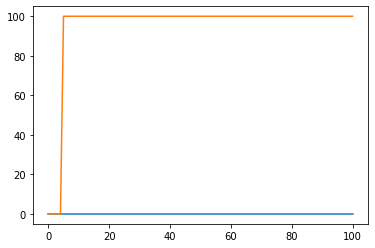

In [10]:
import numpy as np
import pandas as pd
n = 101
t = np.linspace(0,100,101)
u = np.zeros(n); u[5:]=100
y = np.zeros(n)

a = [0.6,-0.15,0.46]
b = [0.08]

for i in range(2,n-1):
    k = int(t[i])
    y[k+1] = y[k]  # fill in time-series equation here
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(t,y,t,u)
plt.show()

### Time-Series Regression

Now that you've simulated a time series model, the next step is to determine the coefficients from data. There is a Gekko function `sysid` that automates the process of system identification of a time series model.

![gekko](https://apmonitor.com/che263/uploads/Begin_Python/gekko.png)

You can access the help on this function with `help(m.sysid)`. Some of the help is shown below.

    y,p,K = sysid(t,u,y,na=1,nb=1,shift='calc',pred='model')

    Input:     t = time data
               u = input data for the regression
               y = output data for the regression   
               na   = number of output coefficients (default=1)
               nb   = number of input coefficients (default=1)
               nk   = input delay steps (default=0)
               shift (optional) = 
                  'none' (no shift)
                  'init' (initial pt),
                  'mean' (mean center)
                  'calc' (calculate c)
               pred (option) = 
                  'model' for output error regression form, implicit solution
                  'meas' for ARX regression form, explicit solution
                  Using 'model' favors an unbiased model prediction but
                    can require more time to compute, especially for large
                    data sets
                  Using 'meas' computes the coefficients of the time series
                    model with an explicit solution
               
    Output:    returns
               ypred (predicted outputs)
               p as coefficient dictionary with keys 'a','b','c'
               K gain matrix
               
There are many options such as `pred` as `meas` or `model`. With `meas`, the time-series next step is predicted from prior measurements as in `ARX` form. With `model`, it uses the prior model predictions to predict the next time step. This is also called an Output Error (`OE`) model. You should use `pred=meas` if it is a big data set because it will be much faster to solve.

The most important thing to decide is how many coefficients to include in the model by setting `na` and `nb`. It is important to start with small numbers and only add additional coefficients if more accuracy is needed to predict higher-order dynamics. Another factor is `shift` where `init` is preferred if you are starting from steady state conditions. Otherwise `mean` or `calc` are good options to create an unbiased model that does not have offset in the predictions.

![expert](https://apmonitor.com/che263/uploads/Begin_Python/expert.png)

Change the number of coefficients `na` and `nb` and observe the accuracy of the predictions. Also, set `na=2` and `nb=2` and change `pred=model`.

```python
na = 2 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,pred='meas')
```

How much longer does it take to solve as you increase the number of coefficient or change `pred`? You can time a function with:

```python
import time
start = time.time()
### the function
print('Elapsed time: ' + str(time.time()-start))
```

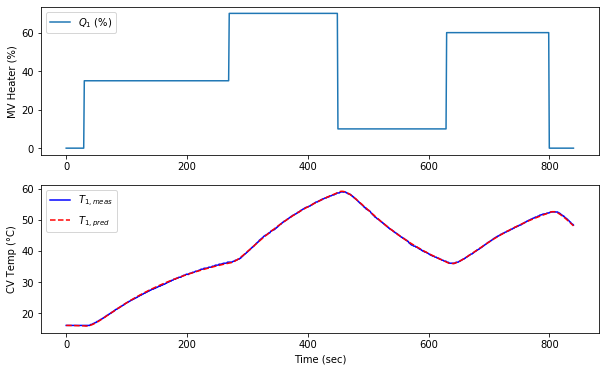

In [25]:
from gekko import GEKKO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load data and parse into columns
url = 'http://apmonitor.com/pdc/uploads/Main/tclab_data4.txt'
data = pd.read_csv(url)
t = data['Time']
u = data['Q1']
y = data['T1']

# generate time-series model
m = GEKKO(remote=False)

# system identification
na = 2 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,pred='meas')

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$Q_1$ (%)'])
plt.ylabel('MV Heater (%)')
plt.subplot(2,1,2)
plt.plot(t,y,'b-',label=r'$T_{1,meas}$')
plt.plot(t,yp,'r--',label=r'$T_{1,pred}$')
plt.legend(); plt.ylabel('CV Temp (°C)')
plt.xlabel('Time (sec)'); plt.savefig('12-sysid.png')

### Simulate Time-Series

There may also be multiple inputs and multiple outputs such as when $n_a$=2, $n_b$=1, $n_u$=2, and $n_y$=2.

$y_{1,k+1} = a_{1,1} \, y_{1,k} + a_{2,1} \, y_{1,k-1} + b_{1,1} \, u_{1,k} + b_{1,2} \, u_{2,k}$

$y_{2,k+1} = a_{1,2} \, y_{2,k} + a_{2,2} \, y_{2,k-1} + b_{2,1} \, u_{1,k} + b_{2,2} \, u_{2,k}$

Gekko has the `arx` model that solves time series models once they are identified. It requires a Python dictionary with $A\in\mathbb{R}^{n_a \, \mathrm{x} \, n_y}$, $B\in\mathbb{R}^{n_y \, \mathrm{x} \, \left(n_b \mathrm{x} n_u\right)}$, and $C\in\mathbb{R}^{n_y}$ coefficient matrices. This dictionary is automatically created with the Gekko `sysid` (system identification) function. Below is an example of creating the dictionary manually.

```python
    # python dictionary
    p = {'a':A,'b':B,'c':C}
```

$A = \begin{bmatrix}0.36788 & 0.36788 \\ 0.223 & -0.136\end{bmatrix}$
$B = \begin{bmatrix}0.63212 & 0.18964 \\ 0.31606 & 1.2642\end{bmatrix}$
$C = \begin{bmatrix}0 & 0\end{bmatrix}$

[Additional tutorials on Gekko](https://apmonitor.com/wiki/index.php/Main/GekkoPythonOptimization) show how to solve other types of equations and optimization problems.

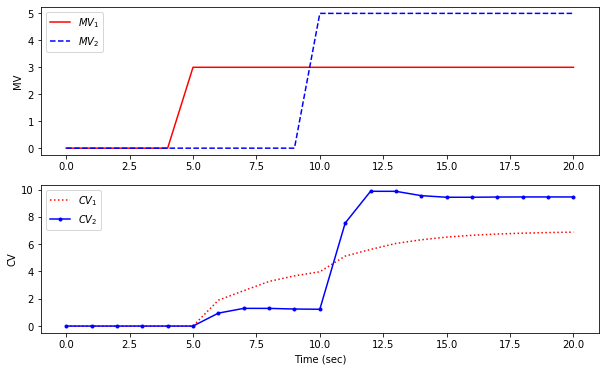

In [13]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt
%matplotlib inline

na = 2 # Number of A coefficients
nb = 1 # Number of B coefficients
ny = 2 # Number of outputs
nu = 2 # Number of inputs

# A (na x ny)
A = np.array([[0.36788,0.36788],\
              [0.223,-0.136]]) 
# B (ny x (nb x nu))
B1 = np.array([0.63212,0.18964]).T
B2 = np.array([0.31606,1.26420]).T
B = np.array([[B1],[B2]])

C = np.array([0,0])

# create parameter dictionary
p = {'a':A,'b':B,'c':C}

# Create GEKKO model
m = GEKKO(remote=False)

# Build GEKKO ARX model
y,u = m.arx(p)

# load inputs
tf = 20 # final time
u1 = np.zeros(tf+1)
u2 = u1.copy()
u1[5:] = 3.0
u2[10:] = 5.0
u[0].value = u1
u[1].value = u2

# customize names
mv1 = u[0]; mv2 = u[1]
cv1 = y[0]; cv2 = y[1]

# options
m.time = np.linspace(0,tf,tf+1)
m.options.imode = 4; m.options.nodes = 2

# simulate
m.solve(disp=False)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(m.time,mv1.value,'r-',label=r'$MV_1$')
plt.plot(m.time,mv2.value,'b--',label=r'$MV_2$')
plt.ylabel('MV')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(m.time,cv1.value,'r:',label=r'$CV_1$')
plt.plot(m.time,cv2.value,'b.-',label=r'$CV_2$')
plt.ylabel('CV'); plt.xlabel('Time (sec)')
plt.legend(loc='best')
plt.show()

### TCLab Activity

![expert](https://apmonitor.com/che263/uploads/Begin_Python/expert.png)

### Data Collection

![connections](https://apmonitor.com/che263/uploads/Begin_Python/connections.png)

Run the script to generate data for the ARX system identification and the Model Predictive Controller.

In [ ]:
import numpy as np
import pandas as pd
import tclab
import time
import matplotlib.pyplot as plt
%matplotlib inline

# generate step test data on Arduino
filename = '12-tclab.csv'

# heater steps
Q1d = np.zeros(601)
Q1d[10:100] = 80
Q1d[100:200] = 20
Q1d[200:300] = 70
Q1d[300:400] = 50
Q1d[400:500] = 100
Q1d[500:] = 0

Q2d = np.zeros(601)
Q2d[50:150] = 35
Q2d[150:250] = 95
Q2d[250:350] = 25
Q2d[350:450] = 100
Q2d[450:550] = 45
Q2d[550:] = 0

# Connect to Arduino
a = tclab.TCLab()
fid = open(filename,'w')
fid.write('Time,Q1,Q2,T1,T2\n')
fid.close()

# run step test (20 min)
for i in range(601):
    # set heater values
    a.Q1(Q1d[i])
    a.Q2(Q2d[i])
    print('Time: ' + str(2*i) + \
          ' H1: ' + str(Q1d[i]) + \
          ' H2: ' + str(Q2d[i]) + \
          ' T1: ' + str(a.T1)   + \
          ' T2: ' + str(a.T2))
    # wait 2 seconds
    time.sleep(2)
    fid = open(filename,'a')
    fid.write(str(2*i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
              +str(a.T1)+','+str(a.T2)+'\n')
    fid.close()
# close connection to Arduino
a.close()

# read data file
data = pd.read_csv(filename)

# plot measurements
plt.figure()
plt.subplot(2,1,1)
plt.plot(data['Time'],data['H1'],'r-',label='Heater 1')
plt.plot(data['Time'],data['H2'],'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'r.',label='Temperature 1')
plt.plot(data['Time'],data['T2'],'b.',label='Temperature 2')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('12-tclab.png')

plt.show()

![expert](https://apmonitor.com/che263/uploads/Begin_Python/expert.png)

### Model Predictive Control with Time Series Model

Run the following application with the TCLab connected. It uses the step test data from above to create a time series model. The application then uses this time series to create a Model Predictive Control application that optimizes the heaters to target temperature values. As the MPC runs, blow on the heaters to cause a disturbance. Observe how the predicted heater profile changes as the disturbance is applied.

<video width="500" height="350" controls src="https://apmonitor.com/do/uploads/Main/tclab_arx_mpc.mp4" />

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import json
# get gekko package with:
#   pip install gekko
from gekko import GEKKO
# get tclab package with:
#   pip install tclab
from tclab import TCLab

# Connect to Arduino
a = TCLab()

# Final time
tf = 10 # min
# number of data points (every 2 seconds)
n = tf * 30 + 1

# Percent Heater (0-100%)
Q1s = np.zeros(n)
Q2s = np.zeros(n)

# Temperatures (degC)
T1m = a.T1 * np.ones(n)
T2m = a.T2 * np.ones(n)
# Temperature setpoints
T1sp = T1m[0] * np.ones(n)
T2sp = T2m[0] * np.ones(n)

# Heater set point steps about every 150 sec
T1sp[3:] = 50.0
T2sp[40:] = 35.0
T1sp[80:] = 30.0
T2sp[120:] = 50.0
T1sp[160:] = 45.0
T2sp[200:] = 35.0
T1sp[240:] = 60.0

#########################################################
# Initialize Model
#########################################################
# load data (20 min, dt=2 sec) and parse into columns
data = pd.read_csv('12-tclab.csv')
t = data['Time']
u = data[['Q1','Q2']]
y = data[['T1','T2']]

# generate time-series model
m = GEKKO(remote=False)

##################################################################
# system identification
na = 2 # output coefficients
nb = 2 # input coefficients
print('Identify model')
yp,p,K = m.sysid(t,u,y,na,nb,objf=10000,scale=False,diaglevel=1)

##################################################################
# plot sysid results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$H_1$',r'$H_2$'])
plt.ylabel('MVs')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.legend([r'$T_{1meas}$',r'$T_{2meas}$',\
            r'$T_{1pred}$',r'$T_{2pred}$'])
plt.ylabel('CVs')
plt.xlabel('Time')
plt.savefig('sysid.png')
plt.show()

##################################################################
# create control ARX model
y = m.Array(m.CV,2)
u = m.Array(m.MV,2)
m.arx(p,y,u)

# rename CVs
TC1 = y[0]
TC2 = y[1]

# rename MVs
Q1 = u[0]
Q2 = u[1]

# steady state initialization
m.options.IMODE = 1
m.solve(disp=False)

# set up MPC
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT
m.time=np.linspace(0,120,61)

# Manipulated variables
Q1.STATUS = 1  # manipulated
Q1.FSTATUS = 0 # not measured
Q1.DMAX = 50.0
Q1.DCOST = 0.1
Q1.UPPER = 100.0
Q1.LOWER = 0.0

Q2.STATUS = 1  # manipulated
Q2.FSTATUS = 0 # not measured
Q2.DMAX = 50.0
Q2.DCOST = 0.1
Q2.UPPER = 100.0
Q2.LOWER = 0.0

# Controlled variables
TC1.STATUS = 1     # drive to set point
TC1.FSTATUS = 1    # receive measurement
TC1.TAU = 20       # response speed (time constant)
TC1.TR_INIT = 2    # reference trajectory
TC1.TR_OPEN = 0

TC2.STATUS = 1     # drive to set point
TC2.FSTATUS = 1    # receive measurement
TC2.TAU = 20        # response speed (time constant)
TC2.TR_INIT = 2    # dead-band
TC2.TR_OPEN = 1

##################################################################
# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
    for i in range(1,n-1):
        # Sleep time
        sleep_max = 2.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Celsius 
        T1m[i] = a.T1
        T2m[i] = a.T2

        # Insert measurements
        TC1.MEAS = T1m[i]
        TC2.MEAS = T2m[i]

        # Adjust setpoints
        db1 = 1.0 # dead-band
        TC1.SPHI = T1sp[i] + db1
        TC1.SPLO = T1sp[i] - db1

        db2 = 0.2
        TC2.SPHI = T2sp[i] + db2
        TC2.SPLO = T2sp[i] - db2

        # Adjust heaters with MPC
        m.solve() 

        if m.options.APPSTATUS == 1:
            # Retrieve new values
            Q1s[i+1]  = Q1.NEWVAL
            Q2s[i+1]  = Q2.NEWVAL
            # get additional solution information
            with open(m.path+'//results.json') as f:
                results = json.load(f)
        else:
            # Solution failed
            Q1s[i+1]  = 0.0
            Q2s[i+1]  = 0.0

        # Write new heater values (0-100)
        a.Q1(Q1s[i])
        a.Q2(Q2s[i])

        # Plot
        plt.clf()
        ax=plt.subplot(3,1,1)
        ax.grid()
        plt.plot(tm[0:i+1],T1sp[0:i+1]+db1,'k-',\
                 label=r'$T_1$ target',linewidth=3)
        plt.plot(tm[0:i+1],T1sp[0:i+1]-db1,'k-',\
                 label=None,linewidth=3)
        plt.plot(tm[0:i+1],T1m[0:i+1],'r.',label=r'$T_1$ measured')
        plt.plot(tm[i]+m.time,results['v1.bcv'],'r-',\
                 label=r'$T_1$ predicted',linewidth=3)
        plt.plot(tm[i]+m.time,results['v1.tr_hi'],'k--',\
                 label=r'$T_1$ trajectory')
        plt.plot(tm[i]+m.time,results['v1.tr_lo'],'k--')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(3,1,2)
        ax.grid()        
        plt.plot(tm[0:i+1],T2sp[0:i+1]+db2,'k-',\
                 label=r'$T_2$ target',linewidth=3)
        plt.plot(tm[0:i+1],T2sp[0:i+1]-db2,'k-',\
                 label=None,linewidth=3)
        plt.plot(tm[0:i+1],T2m[0:i+1],'b.',label=r'$T_2$ measured')
        plt.plot(tm[i]+m.time,results['v2.bcv'],'b-',\
                 label=r'$T_2$ predict',linewidth=3)
        plt.plot(tm[i]+m.time,results['v2.tr_hi'],'k--',\
                 label=r'$T_2$ range')
        plt.plot(tm[i]+m.time,results['v2.tr_lo'],'k--')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(3,1,3)
        ax.grid()
        plt.plot([tm[i],tm[i]],[0,100],'k-',\
                 label='Current Time',linewidth=1)
        plt.plot(tm[0:i+1],Q1s[0:i+1],'r.-',\
                 label=r'$Q_1$ history',linewidth=2)
        plt.plot(tm[i]+m.time,Q1.value,'r-',\
                 label=r'$Q_1$ plan',linewidth=3)
        plt.plot(tm[0:i+1],Q2s[0:i+1],'b.-',\
                 label=r'$Q_2$ history',linewidth=2)
        plt.plot(tm[i]+m.time,Q2.value,'b-',
                 label=r'$Q_2$ plan',linewidth=3)
        plt.plot(tm[i]+m.time[1],Q1.value[1],color='red',\
                 marker='.',markersize=15)
        plt.plot(tm[i]+m.time[1],Q2.value[1],color='blue',\
                 marker='X',markersize=8)
        plt.ylabel('Heaters')
        plt.xlabel('Time (sec)')
        plt.legend(loc=2)
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters and close connection
    a.Q1(0)
    a.Q2(0)
    a.close()
    # Save figure
    plt.savefig('12-tclab_mpc.png')

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Turn off heaters and close connection
    a.Q1(0)
    a.Q2(0)
    a.close()
    print('Shutting down')
    plt.savefig('12-tclab_mpc.png')

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    a.close()
    print('Error: Shutting down')
    plt.savefig('12-tclab_mpc.png')
    raise